In [82]:
import requests
import pandas as pd
import tweepy
import os
import json
import sys
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from functools import reduce
from datetime import datetime
from bs4 import BeautifulSoup

%matplotlib inline
np.random.seed = 42

Read the given csv archive.

In [83]:
df_main = pd.read_csv('twitter-archive-enhanced.csv')
df_main.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [84]:
df_main.shape

(2356, 17)

Download image predictions data and save it into a csv file.

In [85]:
# r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
# with open('image_predictions.tsv', 'w') as image_predictions_file:
#     image_predictions_file.write(r.text)

In [86]:
df_predictions = pd.read_csv('image_predictions.tsv', '\t')

In [87]:
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [88]:
df_predictions.shape

(2075, 12)

Now let's connect to Twitter API and get an instance of tweepy.API object. All Twitter Developer credentials are stored on the system.

In [89]:
# auth = tweepy.OAuthHandler(os.environ['TWITTER_CONS_API_KEY'], os.environ['TWITTER_CONS_API_SECRET'])
# auth.set_access_token(os.environ['TWITTER_ACCESS_TOKEN'], os.environ['TWITTER_ACCESS_SECRET'])

# api = tweepy.API(auth)

In [90]:
# counter = 1
# failed_tweets = []
# num_tweets = len(df_main.tweet_id)
# with open('tweet_json.txt', 'w') as tweet_json:
#     for tweet_id in df_main.tweet_id:
#         try:
#             data = api.get_status(tweet_id)._json
#             tweet_json.write(json.dumps(data))
#             tweet_json.write('\n')
#         except:
#             failed_tweets.append(tweet_id)
#         # print the percentage of tweets processed and move caret back to the start of the line
#         # to overwrite on next print
#         print('{:3.0%}'.format(counter / num_tweets), end='\r', flush=True)
#         counter += 1

Test the processing.

In [91]:
# with open('tweet_json.txt', 'r') as tweet_json:
#     assert len(df_main.tweet_id) == len(list(tweet_json)) + len(failed_tweets)

In [92]:
# len(failed_tweets)

In [93]:
df_tweet_data = pd.DataFrame(columns=['tweet_id', 'likes', 'retweets'])
with open('tweet_json.txt', 'r') as tweet_json:
    for line in tweet_json:
        tweet_j = json.loads(line)
        df_tweet_data = df_tweet_data.append(pd.DataFrame({
            'tweet_id': tweet_j['id'],
            'likes': tweet_j['favorite_count'],
            'retweets': tweet_j['retweet_count']
        }, index=[0]), ignore_index=True)

df_tweet_data.dtypes

tweet_id    object
likes       object
retweets    object
dtype: object

We need to convert `likes` and `retweets` to numeric type.

In [94]:
df_tweet_data.likes = pd.to_numeric(df_tweet_data.likes)
df_tweet_data.retweets = pd.to_numeric(df_tweet_data.retweets)
df_tweet_data.dtypes

tweet_id    object
likes        int64
retweets     int64
dtype: object

In [95]:
df_tweet_data.head()

,tweet_id,likes,retweets
0,892420643555336193,38198,8368
1,892177421306343426,32751,6178
2,891815181378084864,24667,4089
3,891689557279858688,41524,8495
4,891327558926688256,39715,9208


# Data Assessment

## Data Issues

### Programmatic and Visual Analysis

In [96]:
df_main.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [97]:
df_predictions.shape, df_main.shape

((2075, 12), (2356, 17))

In [98]:
df_tweet_data.shape, df_main.shape

((1212, 3), (2356, 17))

Let's see what kind of data the `source` column has.

In [99]:
df_main.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

Let's check the types of `doggo`, `pupper`, `puppo` and `floofer` columns and if they are unique per row.

In [100]:
print(df_main[['doggo', 'pupper', 'puppo', 'floofer']].dtypes)
print(df_main.doggo.unique())
print(df_main.pupper.unique())
print(df_main.puppo.unique())
print(df_main.floofer.unique())

doggo      object
pupper     object
puppo      object
floofer    object
dtype: object
['None' 'doggo']
['None' 'pupper']
['None' 'puppo']
['None' 'floofer']


In [101]:
df_main.loc[(df_main[['doggo', 'floofer', 'pupper', 'puppo']] != 'None').sum(axis=1) > 1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None


In [102]:
df_main[['tweet_id',
         'expanded_urls',
         'in_reply_to_status_id',
         'in_reply_to_user_id',
         'retweeted_status_id',
         'retweeted_status_user_id']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
tweet_id                    2356 non-null int64
expanded_urls               2297 non-null object
in_reply_to_status_id       78 non-null float64
in_reply_to_user_id         78 non-null float64
retweeted_status_id         181 non-null float64
retweeted_status_user_id    181 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 110.5+ KB


Now let's check if all `name`s are actual names.

In [103]:
print(df_main.name.dtypes)
df_main.name.value_counts()

object


None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Tucker        10
Lola          10
Penny         10
Bo             9
Winston        9
the            8
Sadie          8
an             7
Bailey         7
Toby           7
Buddy          7
Daisy          7
Jax            6
Bella          6
Stanley        6
Milo           6
Jack           6
Scout          6
Leo            6
Dave           6
Oscar          6
Koda           6
Rusty          6
Sammy          5
            ... 
Trevith        1
Hector         1
Dook           1
Brooks         1
Olaf           1
Flurpson       1
Brat           1
Katie          1
Brandy         1
Duddles        1
Ralphus        1
Rufio          1
Danny          1
Genevieve      1
Rhino          1
Dixie          1
Maya           1
Mason          1
Cannon         1
Jersey         1
Brandi         1
Eriq           1
Leonidas       1
Bobble         1
Clarkus        1
Stewie         1
Jarvis         1
Eevee         

In [104]:
print(df_main.timestamp.dtype)
print(df_main.timestamp.head())

object
0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object


Let's check if `rating_numerator` has been extracted properly. This omits some eye-balling process.

In [105]:
print(df_main.rating_numerator.dtype)
print(df_main.rating_numerator.unique())
print(df_main.text.values[45], df_main.rating_numerator.values[45])

int64
[  13   12   14    5   17   11   10  420  666    6   15  182  960    0
   75    7   84    9   24    8    1   27    3    4  165 1776  204   50
   99   80   45   60   44  143  121   20   26    2  144   88]
This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948 5


Some predictions seem to be non-breeds. This required some eye-balling as well.

In [106]:
df_predictions[df_predictions.index == 1138]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1138,729113531270991872,https://pbs.twimg.com/media/Ch5U4FzXEAAShhF.jpg,2,stone_wall,0.606188,False,prison,0.064831,False,bannister,0.048048,False


In [107]:
(df_predictions['p1'] == 'stone_wall').any()

True

### Quality Isuses

1. `doggo`, `pupper`, `puppo` and `floofer` have type string with only two observation values per column represented as `column name` and `None`.
2. Some dogs have more than one dog type identified.
3. `df_predictions` has less data points than `df_main`.
4. `df_tweet_data` has less data points than `df_main`.
5. `source` column of `df_main` contains meaningless data.
6. Observations in `df_main` that indicate retweets, i.e. the ones that have values in `in_reply_to_status_id` or `retweeted_status_id` should be removed as we don't analyse retweets, only original tweets.
7. `expanded_urls` has insufficient data and redundant as it can be reconstructed from `tweet_id`.
8. `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id` and `retweeted_status_user_id` all have `float` data type.
9. Some values in `name` are not names (like "a", "an" or "the").
10. `name` column has missing data.
11. `rating_numerator` is not properly extracted, there are `float` values which are extracted as `integer`. 
12. `timestamp` column has `date` type where displaying it in Unix time is more convenient for analysis.
13. `df_predictions` have non-breeds as breed predictions.

### Tidiness Issues

1. `doggo`, `pupper`, `puppo` and `floofer` are values of 'type of dog' variable, that are used as variables in the data set which contradicts the rule number 1<sup>[1]</sup> of tidy data.
2. Main data set contains sets of data that don't belong in the same table like 'tweet id - tweet text' and 'tweet id - dog data' associations which is contrary to rule 3<sup>[1]</sup>.

# Data Cleaning

## Quality Improvements

First, let's copy original DataFrame.

In [108]:
df_main_clean = df_main.copy()

    1.1. DEFINE

    `doggo`, `pupper`, `puppo` and `floofer` have type string with only two observation values per column represented as `column name` and `None` and some dogs have more than one dog type identified. Join `doggo`, `pupper`, `puppo` and `floofer` into a single column with category data type and combine multiple observations where applicable into one.

    1.2. CODE

In [109]:
df_main_clean[['doggo', 'pupper', 'puppo', 'floofer']] = df_main_clean[['doggo', 'pupper', 'puppo', 'floofer']].replace('None', np.nan)
df_main_clean['dog_type'] = df_main_clean[['doggo', 'pupper', 'puppo', 'floofer']].apply(lambda s: pd.Series(reduce(lambda r, i: r if i is np.nan else str(i) if r is None else 'multiple', s, None)), axis=1)
df_main_clean['dog_type'] = df_main_clean['dog_type'].astype('category')

    1.3. TEST

In [110]:
df_main_clean[['dog_type']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 1 columns):
dog_type    380 non-null category
dtypes: category(1)
memory usage: 2.6 KB


In [111]:
df_main_clean.dog_type.unique()

[NaN, doggo, puppo, pupper, floofer, multiple]
Categories (5, object): [doggo, puppo, pupper, floofer, multiple]

    2.1. DEFINE
    
    `source` column of `df_main` contains meaningless data. Remove `source` column of `df_main`.
    
    2.2. CODE

In [112]:
df_main_clean.drop('source', axis=1, inplace=True)

    2.3. TEST

In [113]:
assert 'source' not in df_main_clean.columns

    3.1. DEFINE
    
    Observations in `df_main` that indicate retweets, i.e. the ones that have values in `in_reply_to_status_id` or `retweeted_status_id` should be removed as we don't analyse retweets, only original tweets. Remove observations that indicate retweets, i.e. the ones that have values in `in_reply_to_status_id` or `retweeted_status_id`, then drop the columns.
    
    3.2. CODE

In [114]:
df_main_clean = df_main_clean[df_main_clean.in_reply_to_status_id.isnull() & df_main_clean.retweeted_status_id.isnull()]

In [115]:
df_main_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

    3.3. TEST

In [116]:
df_main_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'dog_type'],
      dtype='object')

    4.1. DEFINE
    
    `expanded_urls` has insufficient data and redundant as it can be reconstructed from `tweet_id`. Drop `expanded_urls`.
    
    4.2. CODE

In [117]:
df_main_clean.drop('expanded_urls', axis=1, inplace=True)

    4.3. TEST

In [118]:
df_main_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'dog_type'],
      dtype='object')

    5.1. DEFINE
    
    Some values in `name` are not names (like "a", "an" or "the"). `name` column has missing data. Remove invalid dog names from `name` column.
    
    5.2. CODE

    First let's look at the words that don't look like names.

In [119]:
df_main_clean[df_main_clean.name.str.islower()]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_type
22,887517139158093824,2017-07-19 03:39:09 +0000,I've yet to rate a Venezuelan Hover Wiener. Th...,14,10,such,NaN,NaN,NaN,NaN,NaN
56,881536004380872706,2017-07-02 15:32:16 +0000,Here is a pupper approaching maximum borkdrive...,14,10,a,NaN,NaN,pupper,NaN,pupper
169,859196978902773760,2017-05-02 00:04:57 +0000,We only rate dogs. This is quite clearly a smo...,12,10,quite,NaN,NaN,NaN,NaN,NaN
193,855459453768019968,2017-04-21 16:33:22 +0000,"Guys, we only rate dogs. This is quite clearly...",12,10,quite,NaN,NaN,NaN,NaN,NaN
335,832645525019123713,2017-02-17 17:38:57 +0000,There's going to be a dog terminal at JFK Airp...,10,10,not,NaN,NaN,NaN,NaN,NaN
369,828650029636317184,2017-02-06 17:02:17 +0000,"Occasionally, we're sent fantastic stories. Th...",14,10,one,NaN,NaN,NaN,NaN,NaN
542,806219024703037440,2016-12-06 19:29:28 +0000,We only rate dogs. Please stop sending in non-...,11,10,incredibly,NaN,NaN,NaN,NaN,NaN
649,792913359805018113,2016-10-31 02:17:31 +0000,Here is a perfect example of someone who has t...,13,10,a,NaN,NaN,NaN,NaN,NaN
801,772581559778025472,2016-09-04 23:46:12 +0000,Guys this is getting so out of hand. We only r...,10,10,a,NaN,NaN,NaN,NaN,NaN
819,770655142660169732,2016-08-30 16:11:18 +0000,We only rate dogs. Pls stop sending in non-can...,11,10,very,NaN,NaN,NaN,NaN,NaN


In [120]:
df_inv_names = df_main_clean[df_main_clean.name.str.islower()][['text', 'name']]

In [121]:
s_names = df_inv_names[df_inv_names.text.str.contains('named')].apply(lambda s: s[0].split(' ')[s[0].split(' ').index('named') + 1].strip('.'), axis=1)
s_names

1853        Wylie
1955          Kip
2034        Jacob
2066        Rufus
2116        Spork
2125     Cherokee
2128        Hemry
2146      Alphred
2161      Alfredo
2191        Leroi
2204        Berta
2218         Chuk
2235      Alfonso
2249       Cheryl
2255      Jessiga
2264        Klint
2273         Kohl
2304         Pepe
2311    Octaviath
2314         Johm
dtype: object

In [122]:
df_main_clean.loc[s_names.index, 'name'] = s_names

In [123]:
s_names = df_inv_names[df_inv_names.text.str.contains('name is')].apply(lambda s: s[0].split(' ')[s[0].split(' ').index('name') + 2].strip('.'), axis=1)
s_names

852      Zoey
2287    Daryl
dtype: object

In [124]:
df_main_clean.loc[992, 'name'] = 'Quizno'
df_main_clean.loc[852, 'name'] = 'Zoey'
df_main_clean.loc[2287, 'name'] = 'Daryl'

     5.3. TEST

In [125]:
df_main_clean[df_main_clean.name.str.islower()].shape

(81, 11)

    We replaced 23 names.

    6.1. DEFINE
    
    `timestamp` column has `date` type where displaying it in Unix time is more convenient for analysis. Convert `timestamp` column into Unix time.
    
    6.2. CODE

In [126]:
df_main_clean.timestamp = df_main_clean.timestamp.apply(lambda t: int((datetime.strptime(t, "%Y-%m-%d %H:%M:%S %z").replace(tzinfo=None) - datetime(1970, 1, 1)).total_seconds()))

    6.3. TEST

In [127]:
print(df_main_clean.timestamp.dtype)
df_main_clean.timestamp.head()

int64


0    1501604636
1    1501546647
2    1501460283
3    1501430331
4    1501344024
Name: timestamp, dtype: int64

    7.1. DEFINE
    
    `df_predictions` have non-breeds as breed predictions. Drop rows that contain non-breed observations in `df_predictions`.
    
    7.2. CODE

    For that let's first compile a list of dog breeds.

In [128]:
df_pred_clean = df_predictions.copy()

In [129]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_dog_breeds')
breeds_html = r.text
    
soup = BeautifulSoup(breeds_html, 'html.parser')

In [130]:
breed_table_rows = soup.find_all('table')[0].find('tbody').find_all('tr')[1:-1]
breeds = []
errors = []
for breed_row in breed_table_rows:
    try:
        breed_cell = breed_row.find_all('td')[0]
        breed_link_text = breed_cell.find('a').contents[0]
        breeds.append(breed_link_text)
    except:
        errors.append(breed_row)

In [131]:
breeds

['Affenpinscher',
 'Afghan Hound',
 'Afghan Shepherd',
 'Aidi',
 'Airedale Terrier',
 'Akbash',
 'Akita',
 'Alano Español',
 'Alaskan husky',
 'Alaskan Klee Kai',
 'Alaskan Malamute',
 'Alaunt',
 'Alopekis',
 'Alpine Dachsbracke',
 'Alpine Mastiff',
 'Alpine Spaniel',
 'American Akita',
 'American Bulldog',
 'American Cocker Spaniel',
 'American English Coonhound',
 'American Eskimo Dog',
 'American Foxhound',
 'American Hairless Terrier',
 'American Pit Bull Terrier',
 'American Staffordshire Terrier',
 'American Water Spaniel',
 'Anatolian Shepherd Dog',
 'Andalusian Hound',
 'Anglo-Français de Petite Vénerie',
 'Appenzeller Sennenhund',
 "Braque de l'Ariege",
 'Ariegeois',
 'Armant',
 'Armenian Gampr dog',
 'Artois Hound',
 'Australian Cattle Dog',
 'Australian Kelpie',
 'Australian Shepherd',
 'Australian Silky Terrier',
 'Australian Stumpy Tail Cattle Dog',
 'Australian Terrier',
 'Austrian Black and Tan Hound',
 'Austrian Pinscher',
 'Azawakh',
 'Bakharwal dog',
 'Barbet',
 'Base

In [132]:
errors

[]

In [133]:
breeds += ['Pembroke', 'Cardigan', 'toy_poodle', 'chow', 'cocker_spaniel',
       'Eskimo_dog', 'Staffordshire_bullterrier', 'malamute', 'Pekinese',
       'kelpie', 'miniature_poodle', 'collie', 'Boston_bull',
       'toy_terrier', 'Shih-Tzu', 'Maltese_dog', 'bull_mastiff', 'basset', 'malinois',
       'standard_poodle', 'Airedale', 'English_springer',
       'dingo', 'Brittany_spaniel', 'redbone', 'Lhasa', 'German_short-haired_pointer', 'Saint_Bernard',
          'Doberman', 'Walker_hound', 'Japanese_spaniel',
       'Brabancon_griffon', 'black-and-tan_coonhound', 'Appenzeller', 'Blenheim_spaniel', 'groenendael', 'Dandie_Dinmont', 'Leonberg']

In [134]:
breeds += [breed.replace('_dog', '') for breed in breeds]
breeds = [breed.replace(' ', '_').lower() for breed in breeds]

    Now create a mask of values which are not in the list of dog breeds.

In [135]:
mask = df_pred_clean[df_pred_clean[['p1', 'p2', 'p3']].apply(lambda s: pd.Series(s.str.lower())).apply(lambda s: pd.Series(~s.isin(breeds)))]

In [136]:
mask.p1.append(mask.p2).append(mask.p3).value_counts().keys()

Index(['seat_belt', 'German_shepherd', 'teddy', 'doormat', 'Siamese_cat',
       'ice_bear', 'web_site', 'bath_towel', 'bathtub', 'tennis_ball',
       ...
       'tiger_shark', 'lesser_panda', 'spindle', 'go-kart', 'drake', 'pretzel',
       'wok', 'hammer', 'sandal', 'bullfrog'],
      dtype='object', length=523)

    A lot of values which are dogs were not in a breed list. I eyeballed them and iteratively added them to the list. There can still be some breeds missing, but that should not affect validity of data that much anymore.

    Then let's apply the mask and drop rows which contain NaN values (i.e. values that are non-NaN in mask).

In [137]:
df_pred_clean = df_pred_clean[mask.isnull()].dropna()

    Let's also normalise breed values for easier search and comparison.

In [138]:
df_pred_clean[['p1', 'p2', 'p3']] = df_pred_clean[['p1', 'p2', 'p3']].apply(lambda s: pd.Series(s.str.lower()))

    7.3. TEST

In [139]:
(df_pred_clean['p1'].isin(mask.p1.append(mask.p2).append(mask.p3).value_counts().head(20).keys())).any()

False

In [140]:
df_pred_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,bernese_mountain_dog,0.651137,True,english_springer,0.263788,True,greater_swiss_mountain_dog,0.016199,True


    8.1. DEFINE
    
    `rating_numearator` is not properly extracted, there are `float` values which are extracted as `integer`. Let's extract them properly.
    
    8.2. CODE

In [141]:
df_main_clean.rating_numerator = df_main_clean.rating_numerator.astype(float)

In [142]:
df_main_clean.rating_numerator = df_main_clean.text.str.extract('(\d+\.?\d+)(?=/\d+)').astype(float)

    8.3. TEST

In [143]:
df_main_clean.rating_numerator.unique()

array([  13.  ,   12.  ,   14.  ,   13.5 ,   11.  ,     nan,   10.  ,
         84.  ,   24.  ,    9.75,   11.27,  165.  , 1776.  ,  204.  ,
         50.  ,   99.  ,   80.  ,   45.  ,   60.  ,   44.  ,  121.  ,
         11.26,  144.  ,   88.  ,  420.  ])

## Tidiness Improvements

    1.1. DEFINE
    
    `doggo`, `pupper`, `puppo` and `floofer` are values of 'type of dog' variable, that are used as variables in the data set. Dog types have been joined previously during data quality improvements, so let's just drop them.
    
    1.2. CODE

In [144]:
df_main_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

    1.3. TEST

In [145]:
df_main_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'dog_type'],
      dtype='object')

    2.1. DEFINE
 
    Data is spread across multiple tables. Let's merge all the data into `df_main_clean`.
    
    2.2. CODE
    
    First, ensure that the columns we'll merge on are of the same type.

In [146]:
df_main_clean.tweet_id = df_main_clean.tweet_id.astype(str)
df_pred_clean.tweet_id = df_pred_clean.tweet_id.astype(str)
df_tweet_data.tweet_id = df_tweet_data.tweet_id.astype(str)

In [147]:
df_main_clean = df_main_clean.merge(df_pred_clean, on='tweet_id')

In [148]:
df_main_clean = df_main_clean.merge(df_tweet_data, on='tweet_id')

    2.3. TEST

In [149]:
df_main_clean.head(1)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_type,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,likes,retweets
0,892177421306343426,1501546647,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,32751,6178


Now we need to save the resulting DataFrame into csv file.

In [150]:
df_main_clean.to_csv('twitter_archive_master.csv')

# Analysis

Let's create a couple of helpful functions for data crunching.

In [151]:
def extractRatingByParameter(df):
    ratings = dict()

    def reduceRatingsToSeries(ser):
        if ser[1] in ratings.keys():
            ratings[ser[1]] = ratings[ser[1]].append(pd.Series(ser[0])) 
        else:
            ratings[ser[1]] = pd.Series(ser[0])
    
    df.apply(reduceRatingsToSeries, axis=1)
    return ratings

In [152]:
def calculateAndSort(d, method = 'mean'):
    calcs = {x:getattr(d[x], method)() for x in d.keys()}
    return sorted(calcs.keys(), key=lambda dn: calcs[dn], reverse=True), calcs

def calculateAndSortAlpha(d, method = 'mean'):
    calcs = {x:getattr(d[x], method)() for x in d.keys()}
    return sorted(calcs.keys()), calcs

Let's see which are the most high-rated, liked and retweeted breeds

In [165]:
breed_ratings = extractRatingByParameter(df_main_clean[['rating_numerator', 'p1']])
breed_likes = extractRatingByParameter(df_main_clean[['likes', 'p1']])
breed_retweets = extractRatingByParameter(df_main_clean[['retweets', 'p1']])

In [166]:
sorted_breeds, breed_ratings_mean = calculateAndSort(breed_ratings)
for b in sorted_breeds:
    print(b, breed_ratings_mean[b])

west_highland_white_terrier 29.75
labrador_retriever 15.325581395348838
siberian_husky 15.272727272727273
irish_terrier 13.0
bloodhound 13.0
bedlington_terrier 13.0
yorkshire_terrier 13.0
giant_schnauzer 13.0
afghan_hound 13.0
irish_setter 13.0
curly-coated_retriever 13.0
tibetan_mastiff 13.0
french_bulldog 12.5
italian_greyhound 12.5
eskimo_dog 12.5
saluki 12.5
bernese_mountain_dog 12.5
leonberg 12.5
border_terrier 12.5
briard 12.5
gordon_setter 12.5
standard_poodle 12.5
samoyed 12.428571428571429
schipperke 12.333333333333334
golden_retriever 12.29054054054054
whippet 12.25
great_dane 12.25
pembroke 12.227272727272727
cardigan 12.2
rottweiler 12.2
pekinese 12.166666666666666
basset 12.142857142857142
great_pyrenees 12.142857142857142
chihuahua 12.052631578947368
pug 12.0
english_springer 12.0
irish_water_spaniel 12.0
rhodesian_ridgeback 12.0
toy_poodle 12.0
english_setter 12.0
lakeland_terrier 12.0
old_english_sheepdog 12.0
miniature_schnauzer 12.0
miniature_poodle 12.0
dingo 12.0
to

In [167]:
r_breeds, mean_likes = calculateAndSort(breed_likes)

for b in r_breeds:
    print(b, mean_likes[b])

english_springer 60528.5
lakeland_terrier 52115.666666666664
standard_poodle 48520.5
italian_greyhound 47733.5
french_bulldog 34462.9
giant_schnauzer 33036.0
irish_terrier 27393.0
eskimo_dog 24481.0
irish_water_spaniel 24334.0
tibetan_mastiff 24026.0
saluki 23313.25
bloodhound 22176.0
flat-coated_retriever 21326.833333333332
basset 20910.285714285714
samoyed 20670.714285714286
rottweiler 20298.8
leonberg 20027.5
chihuahua 19246.894736842107
cardigan 17946.0
cocker_spaniel 17760.076923076922
pembroke 17360.782608695652
golden_retriever 16659.76
bernese_mountain_dog 16629.5
norwich_terrier 16628.0
blenheim_spaniel 16627.4
pomeranian 16525.6
west_highland_white_terrier 15803.0
border_terrier 15731.5
chow 15545.64705882353
chesapeake_bay_retriever 15280.083333333334
norwegian_elkhound 15059.333333333334
pug 15009.8
whippet 14998.5
staffordshire_bullterrier 14995.888888888889
labrador_retriever 14803.906976744185
bedlington_terrier 14194.5
great_pyrenees 14158.285714285714
shetland_sheepdog

In [170]:
r_breeds, mean_retweets = calculateAndSort(breed_retweets)

for b in r_breeds:
    print(b, mean_retweets[b])

english_springer 23441.0
standard_poodle 20708.5
lakeland_terrier 17438.0
italian_greyhound 11041.5
giant_schnauzer 9653.0
tibetan_mastiff 9337.0
eskimo_dog 8956.7
french_bulldog 8835.6
samoyed 6829.285714285715
chihuahua 6264.8421052631575
rottweiler 5886.2
irish_water_spaniel 5747.0
flat-coated_retriever 5630.333333333333
cocker_spaniel 5604.153846153846
pomeranian 5539.4
cardigan 5300.3
basset 4939.714285714285
leonberg 4928.0
saluki 4870.25
bloodhound 4688.666666666667
golden_retriever 4523.973333333333
blenheim_spaniel 4507.2
pembroke 4433.369565217391
norwich_terrier 4305.0
irish_terrier 4206.0
norwegian_elkhound 4096.333333333333
chow 4065.705882352941
chesapeake_bay_retriever 3911.8333333333335
pug 3882.9
english_setter 3868.0
shetland_sheepdog 3760.222222222222
labrador_retriever 3738.3255813953488
staffordshire_bullterrier 3712.777777777778
great_pyrenees 3689.0
briard 3670.0
whippet 3629.0
border_terrier 3531.0
afghan_hound 3415.5
miniature_pinscher 3385.7272727272725
bedlin

Next, let's run some number crunching on `likes` and `retweets` and see if the rating correlates with the number of likes and retweets through scatter plots and linear regression.

In [169]:
breeds, mean_ratings = calculateAndSortAlpha(breed_ratings)
breeds, mean_likes = calculateAndSortAlpha(breed_likes)
breeds, mean_retweets = calculateAndSortAlpha(breed_retweets)

df_mean_ratings_likes = pd.DataFrame({'breed': breeds,
                                      'ratings': list(mean_ratings.values()),
                                      'likes': list(mean_likes.values()),
                                      'retweets': list(mean_retweets.values())})

df_mean_ratings_likes = df_mean_ratings_likes.dropna()
# drop top and bottom 10% to avoid extreme values
df_mean_ratings_likes = df_mean_ratings_likes[(df_mean_ratings_likes.ratings.quantile(0.1) < df_mean_ratings_likes.ratings) & (df_mean_ratings_likes.ratings < df_mean_ratings_likes.ratings.quantile(0.9))]

df_mean_ratings_likes['intercept'] = 1
sm.OLS(df_mean_ratings_likes['likes'], df_mean_ratings_likes[['ratings', 'intercept']], missing='drop').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  likes   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     14.94
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           0.000253
Time:                        08:46:59   Log-Likelihood:                -732.94
No. Observations:                  69   AIC:                             1470.
Df Residuals:                      67   BIC:                             1474.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ratings     9513.8742   2461.118      3.866      0.000    4601.462    1.44e+04
intercept  -9.755e+04   2.91e+04     -3.349      0.001   -1.56e+05   -3.94e+04
==============================================================================
Omnibus:                       50.951   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.067
Skew:                           2.274   Prob(JB):                     1.19e-42
Kurtosis:                       9.817   Cond. No.                         286.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

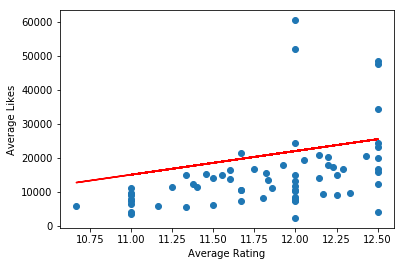

In [155]:
plt.scatter(df_mean_ratings_likes.ratings, df_mean_ratings_likes.likes);
plt.plot(df_mean_ratings_likes.ratings, df_mean_ratings_likes.ratings * 6977 - 61710, color='red');
plt.xlabel('Average Rating');
plt.ylabel('Average Likes');

P-value of 0% indicates that they do weakly correlate and the relation is statistically significant. Now let's see if it holds for retweets.

In [156]:
sm.OLS(df_mean_ratings_likes.retweets, df_mean_ratings_likes[['ratings', 'intercept']], missing='drop').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               retweets   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     10.43
Date:                Sun, 16 Dec 2018   Prob (F-statistic):            0.00192
Time:                        08:29:52   Log-Likelihood:                -665.39
No. Observations:                  69   AIC:                             1335.
Df Residuals:                      67   BIC:                             1339.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ratings     2986.6746    924.665      3.230      0.002    1141.035    4832.314
intercept  -3.112e+04   1.09e+04     -2.843      0.006    -5.3e+04   -9270.829
==============================================================================
Omnibus:                       71.746   Durbin-Watson:                   2.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.252
Skew:                           3.151   Prob(JB):                    5.25e-110
Kurtosis:                      14.633   Cond. No.                         286.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

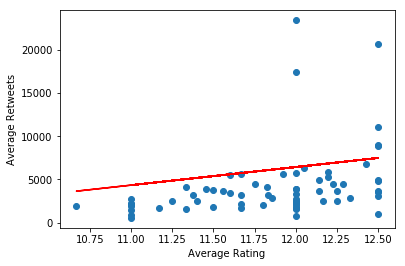

In [173]:
plt.scatter(df_mean_ratings_likes.ratings, df_mean_ratings_likes.retweets);
plt.plot(df_mean_ratings_likes.ratings, df_mean_ratings_likes.ratings * 2096 - 18720, color='red');
plt.xlabel('Average Rating');
plt.ylabel('Average Retweets');

Again, P-value is 0.6% so we can conclude they weakly correlate in a statistically significant way too.

Next, we'll see what's the popularity distribution of each dog type.

In [158]:
type_ratings = extractRatingByParameter(df_main_clean[['rating_numerator', 'dog_type']])
type_ratings_mean = {b:type_ratings[b].mean() for b in type_ratings.keys() if b is not np.nan}
type_ratings_mean

{'doggo': 12.225806451612904,
 'puppo': 12.1875,
 'pupper': 11.805555555555555,
 'floofer': 12.2,
 'multiple': 12.166666666666666}

Let's visualise this.

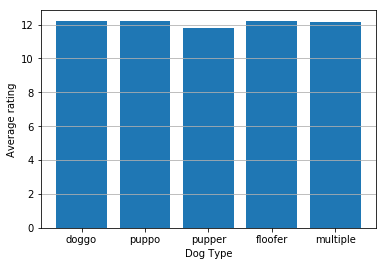

In [159]:
plt.bar(list(type_ratings_mean.keys()), list(type_ratings_mean.values()));
plt.xlabel('Dog Type');
plt.ylabel('Average rating');
plt.grid(axis='y')

We can see that `doggo` is a leader, the goodest of the boys and girls.

Let's build the linear regression for dog types and tweet data and see if there is actually a statistically significant difference.

In [160]:
df_dog_data_w_dummies = df_main_clean.join(pd.get_dummies(df_main_clean.dog_type))
df_dog_data_w_dummies = df_dog_data_w_dummies.dropna()
df_dog_data_w_dummies['intercept'] = 1

In [161]:
sm.OLS(df_dog_data_w_dummies['rating_numerator'], df_dog_data_w_dummies[['intercept', 'doggo', 'puppo', 'pupper', 'floofer']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       rating_numerator   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.6967
Date:                Sun, 16 Dec 2018   Prob (F-statistic):              0.596
Time:                        08:29:55   Log-Likelihood:                -142.91
No. Observations:                  94   AIC:                             295.8
Df Residuals:                      89   BIC:                             308.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.1667      0.464     26.203      0.000      11.244      13.089
doggo          0.0591      0.507      0.117      0.907      -0.949       1.067
puppo          0.0208      0.544      0.038      0.970      -1.061       1.103
pupper        -0.3611      0.502     -0.720      0.473      -1.358       0.635
floofer        0.0333      0.689      0.048      0.962      -1.335       1.402
==============================================================================
Omnibus:                        4.922   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                3.801
Skew:                          -0.370   Prob(JB):                        0.149
Kurtosis:                       2.350   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the above result we can conclude that there's weak and statistically insignificant correlation between dog types and the rating they receive. "They're Good Dogs Brent".

# Appendix

[1] - Tidy data https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html